# Time series analysis

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import requests 
import json
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')

# Get trading data for BTCUSD

Request from Binance API symbol's with hourly interval and create a df.
Increasing the range gives us further data in the past.

In [2]:
df_btcusd = pd.DataFrame()

for x in range(5):
    
    if x == 0: 
    
        response = requests.get('https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1h')
        data_symbol = json.loads(response.text)

        # put in dataframe and drop columns we don't neeed
        df = pd.DataFrame.from_dict(data_symbol)
        df = df.drop(range(6, 12), axis=1)

        # rename columns
        col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = col_names

        # transform values from strings to floats
        for col in col_names[1:6]:
            df[col] = df[col].astype(float)
            
        df = df.sort_values(by='Time', ascending=False, kind='quicksort')
            
        df_btcusd = df_btcusd.append(df)
        
        timestamp = int(df.loc[0, 'Time'])
            
    else:
        
        response = requests.get(f'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1h&endTime={timestamp}')
        data_symbol = json.loads(response.text)
        
        # put in dataframe and drop columns we don't neeed
        df1 = pd.DataFrame.from_dict(data_symbol)
        df1 = df1.drop(range(6, 12), axis=1)
        
                # rename columns
        col_names = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        df1.columns = col_names
        
        # transform values from strings to floats
        for col in col_names[1:6]:
            df1[col] = df1[col].astype(float)
            
        df1.drop(499, inplace=True)
        
        df1 = df1.sort_values(by='Time', ascending=False, kind='quicksort')
        
        df_btcusd = df_btcusd.append(df1)
        
        df_btcusd.reset_index(drop = True, inplace = True)
        
        #df_crypto['Date'] = pd.to_datetime(df1['Time'], unit='ms')
        
        timestamp = int(df1.loc[0, 'Time'])
        
df_btcusd['Date'] = pd.to_datetime(df_btcusd['Time'], unit='ms')

df_btcusd.to_csv('./data_arima/example.csv')

In [3]:
#df_btcusd = pd.read_csv('./data_arima/example.csv', index_col=0)
#df_btcusd.head()

In [4]:
df_btcusd.head()

,Time,Open,High,Low,Close,Volume,Date
0,1584014400000,6064.27,6307.59,5950.0,6089.06,10036.599509,2020-03-12 12:00:00
1,1584010800000,6014.90,6466.00,5750.0,6067.01,26427.576403,2020-03-12 11:00:00
2,1584007200000,7354.99,7367.03,5550.0,6014.90,28792.656130,2020-03-12 10:00:00
3,1584003600000,7378.84,7391.51,7340.0,7354.21,3622.784029,2020-03-12 09:00:00
4,1584000000000,7392.12,7466.00,7310.0,7377.64,6583.236277,2020-03-12 08:00:00


In [5]:
timeseries = df_btcusd.groupby('Date')['Close'].mean()
timeseries.head()

Date
2019-11-29 06:00:00    7471.80
2019-11-29 07:00:00    7509.14
2019-11-29 08:00:00    7501.89
2019-11-29 09:00:00    7565.28
2019-11-29 10:00:00    7535.29
Name: Close, dtype: float64

In [28]:
df = pd.DataFrame(timeseries)
df.tail()

,Close
Date,
2020-03-12 08:00:00,7377.64
2020-03-12 09:00:00,7354.21
2020-03-12 10:00:00,6014.90
2020-03-12 11:00:00,6067.01
2020-03-12 12:00:00,6089.06


As we can see the 2020-03-12 at 09:00:00 the prices due to the corona virus are suffering a fall.

I am for this reason removing the data after that point going forward.

In [33]:
df = df[df.index < '2020-03-12 09:00:00']
df.tail()

,Close
Date,
2020-03-12 04:00:00,7624.30
2020-03-12 05:00:00,7646.95
2020-03-12 06:00:00,7494.17
2020-03-12 07:00:00,7392.13
2020-03-12 08:00:00,7377.64


# Create training and test data

We are looking to predict 3 days forward or 72 hours.

In [34]:
len(df) - 72

2420

In [48]:
train = df.Close[:len(df) - 72]
test = df.Close[len(df) - 72:]

In [49]:
def arimamodel(timeseries):
    '''
     Creating the model: automatic ARIMA using ADF to test stationarity, 
     start values for p and q are set to 1, and the crypto data is not assumed to be seasonal 
 
     Args: 
         timeseries: Pandas timeseries with closing price 
         
     Returns: 
         automodel: automatic ARIMA model
    '''
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [50]:
def plotarima(n_periods, timeseries, automodel):
    ''' 
    Plot ARIMA forecast using statsmodel’s plot_predict, 
        filling the area between the upper and lower prediction bounds.
    
    Args: 
        n_periods: steps for the forecast
        timeseries: Pandas timeseries with closing price 
        automodel: automatic ARIMA model
    '''
    # Hourly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="h")
    # Forecast series
    fc_series = pd.Series(forecast[0], index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(forecast[2][:,0], index=fc_ind)
    upper_series = pd.Series(forecast[2][:,1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(timeseries)
    plt.plot(fc_series, color="blue")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show();

In [51]:
automodel = arimamodel(timeseries)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=26893.887, BIC=26917.176, Fit time=0.437 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=26895.069, BIC=26906.713, Fit time=0.043 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=26894.819, BIC=26912.285, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=26894.952, BIC=26912.419, Fit time=0.119 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=26893.342, BIC=26899.164, Fit time=0.017 seconds
Total fit time: 0.704 seconds


### The Bayesian information criterion (BIC) or Schwarz information criterion (also SIC, SBC, SBIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.

The output of our code suggests that ARIMA(0, 1, 0) yields the lowest BIC value of 6125.350. We should therefore consider this to be optimal option out of all the models we have considered.

# Random walk (0,1,0)

Non-seasonal ARIMA models are denoted as ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model.

In our case being the values (0,1,0) we can confirm that our time series follows the random walk theory.

This means that past points don't affect present.

A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. Examples of random walk include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the financial status of a gambler and the price of a fluctuating stock or criptocurrency like in this case.

### Then we have all we need to fit and plot the model:

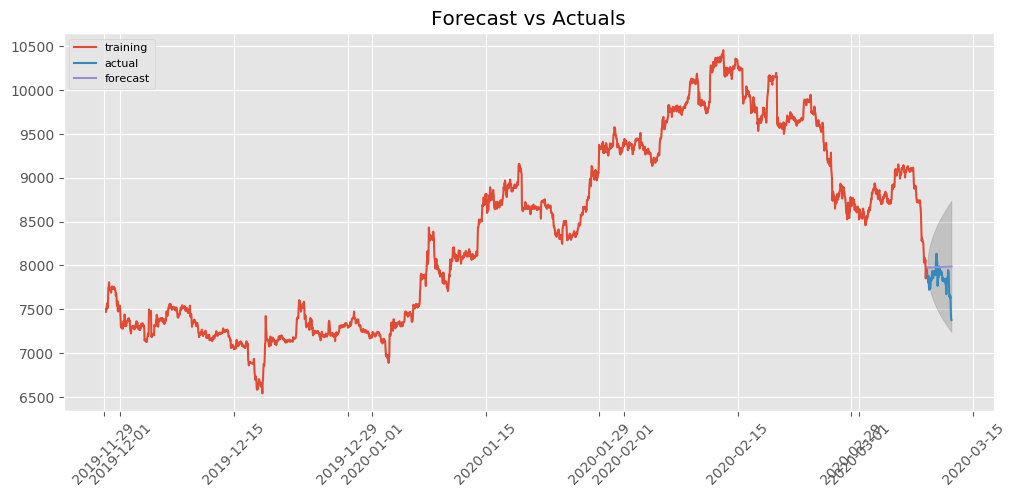

In [52]:
# Build Model
model = ARIMA(train, order=(0, 1, 0))  
model_fit = model.fit()  

# Forecast
fc, se, conf = model_fit.forecast(steps=72, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.xticks(rotation=45)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2496
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -13445.671
Date:                Thu, 12 Mar 2020   AIC                          26893.342
Time:                        14:49:28   BIC                          26899.164
Sample:                             0   HQIC                         26895.456
                               - 2496                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2806.8418      8.548    328.370      0.000    2790.088    2823.595
===================================================================================
Ljung-Box (Q):                       52.75   Jarque-Bera (JB):           3041078.59
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                            -6.88
Prob(H) (two-sided):                  0.00   Kurtosis:                       173.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The P>|z| provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

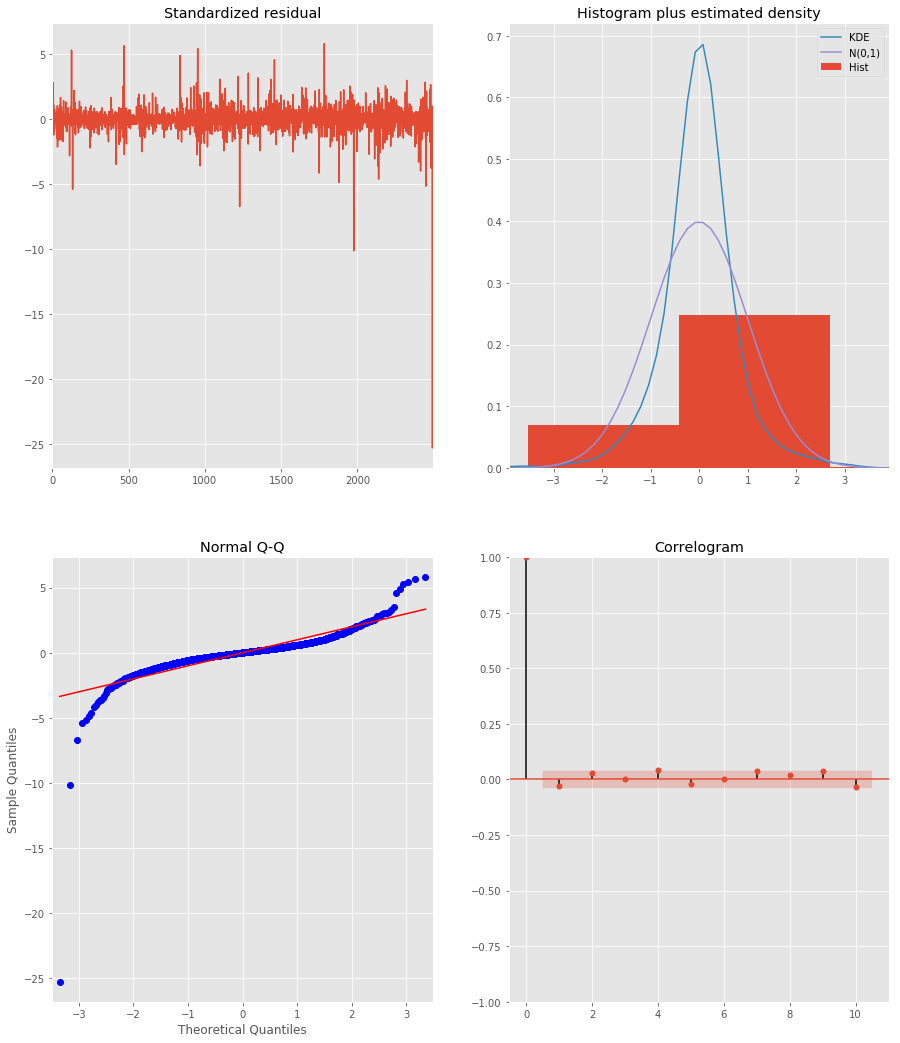

In [54]:
# Call plot_diagnostics() on the results calculated above 
automodel.plot_diagnostics(figsize=(15, 18))
plt.show()

Pretty normal residuals distribution except for the edges where prices are really high or low.

In [15]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2423
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -12657.768
Method:                           css   S.D. of innovations             44.928
Date:                Thu, 12 Mar 2020   AIC                          25319.537
Time:                        12:31:19   BIC                          25331.122
Sample:                             1   HQIC                         25323.749
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1691      0.913      0.185      0.853      -1.620       1.958
